In [ ]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import h5py
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.path import Path
from matplotlib import patches
from matplotlib import rcParams
import seaborn as sns
from PIL import Image

import scanpy as sc

In [2]:
if False:
    fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/dish2_U7.mat'
    data = h5py.File(fn)

    def spell_key(data, key, superkey='objective'):
        a = data[superkey][key][:][:, 0]
        if str(a[0]).isdigit():
            return ''.join([chr(x) for x in a])
        return a

    data_input = data['HAC_Image']['projectStruct']['hardware']
    for key in data_input['camera'].keys():
        print('{}: {}'.format(key, spell_key(data_input, key, superkey='camera')))

In [3]:
def read_image(fn):
    with h5py.File(fn) as f:
        print('Read metadata about excitation/emission lambdas')
        keys = ['excitationWavelength', 'emission']
        wls = {key: [] for key in keys}
        for key in keys:
            tmp = f['HAC_Image']['imageStruct']['protocol']['channel'][key]
            n_colors = tmp.size
            for i in range(n_colors):
                tmpi = f[f[tmp[i, 0]][0, 0]][:, 0]
                wl = int(tmpi.astype(dtype=np.uint8).tobytes().decode())
                wls[key].append(wl)
        wls['combo'] = []
        for i in range(n_colors):
            wls['combo'].append(
                (wls['excitationWavelength'][i], wls['emission'][i]),
                )

        print('Read image data')
        img = f['HAC_Image']['imageStruct']['data'][:, :, :]
    return {
        'data': img,
        'wavelengths': wls['combo'],
        'image': os.path.basename(fn).split('.')[0],
    }

In [15]:
# Panel 2 of figure 1
# plot original brightfield images of 15 channels
# dish2_U7 as the example

fdn_mat = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/'
fdn_images = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/figure1/grid_figures/'

fns_plot = ['dish1_Q11.mat']
for i, fn in enumerate(fns_plot):
    info = read_image(fdn_mat + fn)
    data = info['data']
    wls = info['wavelengths']
    sample = fn.split('.')[0]
    print('sample {}: {}'.format(i, sample))
    for j, wl in enumerate(wls):
        wl_name = str(wl[0]) + '_' + str(wl[1])
        
        dd = (data[i] / data[j].max() * 255).astype(np.uint8)
        img_ori = Image.fromarray(dd.T)
        dd_nor = (dd * 30.0 / np.bincount(dd.ravel()).argmax()).astype(np.uint8)# normalized brightfield
        img_nor = Image.fromarray(dd_nor.T)
        
        fn_ori = fdn_images + 'normal/' + sample
        fn_nor = fdn_images + 'normalized/' + sample
        
        if not os.path.exists(fn_ori):
            os.mkdir(fn_ori)
        img_ori.save(fn_ori + '/' + wl_name + '.png')
            
        if not os.path.exists(fn_nor):
            os.mkdir(fn_nor)
        img_nor.save(fn_nor + '/' + wl_name + '.png')

Read metadata about excitation/emission lambdas
Read image data
sample 0: dish2_U7


Read metadata about excitation/emission lambdas
Read image data
sample 0: dish1_Q11


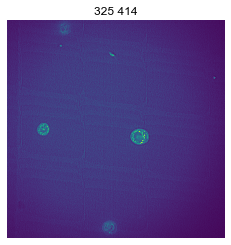

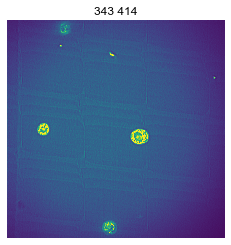

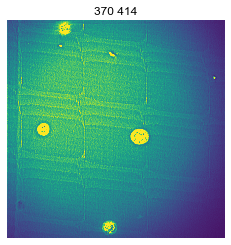

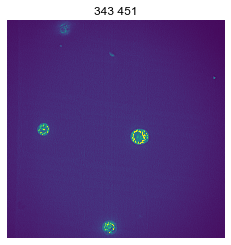

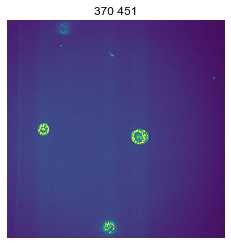

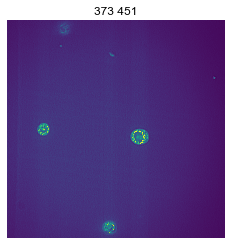

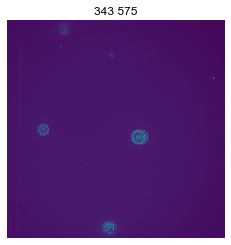

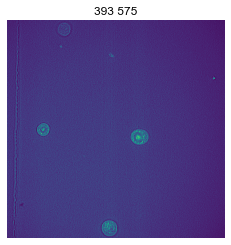

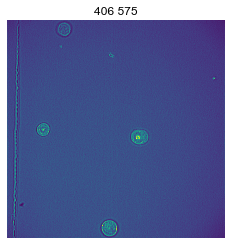

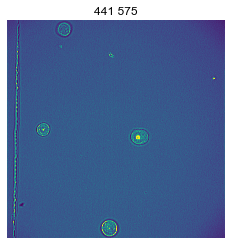

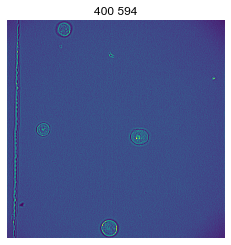

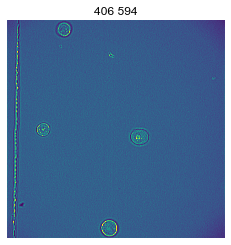

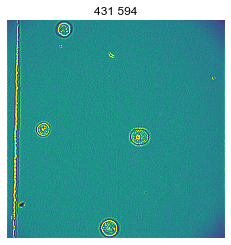

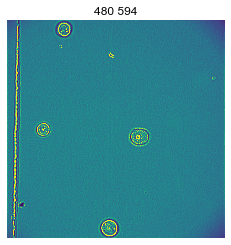

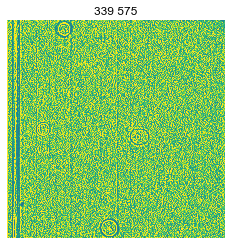

In [27]:
# Panel 2 of figure 1
# plot original images of 15 channels
# dish2_U7 as the example

fdn_mat = '/home/yike/phd/cancer_cells_img_seq/data/20220201_imaging/'
fdn_images = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/figure1/grid_figures/'

fns_plot = ['dish1_Q11.mat']
for i, fn in enumerate(fns_plot):
    info = read_image(fdn_mat + fn)
    data = info['data']
    wls = info['wavelengths']
    sample = fn.split('.')[0]
    print('sample {}: {}'.format(i, sample))
    for j, wl in enumerate(wls):
        wl_name = str(wl[0]) + '_' + str(wl[1])
        
        fig, ax = plt.subplots()
        
        ax.imshow(data[j].T, vmax=10000)
        ax.set_title(wl_name.replace('_', ' '))
        ax.axis('off')
        fn_ori = fdn_images + sample
            
        if not os.path.exists(fn_ori):
            os.mkdir(fn_ori)
        plt.savefig(fn_ori + '/' + wl_name+ '.png', bbox_inches='tight', dpi=150)
#         plt.savefig(fn_ori + '/' + wl_name + '.pdf', bbox_inches='tight', dpi=150)

This is the 0 cell H3_S6


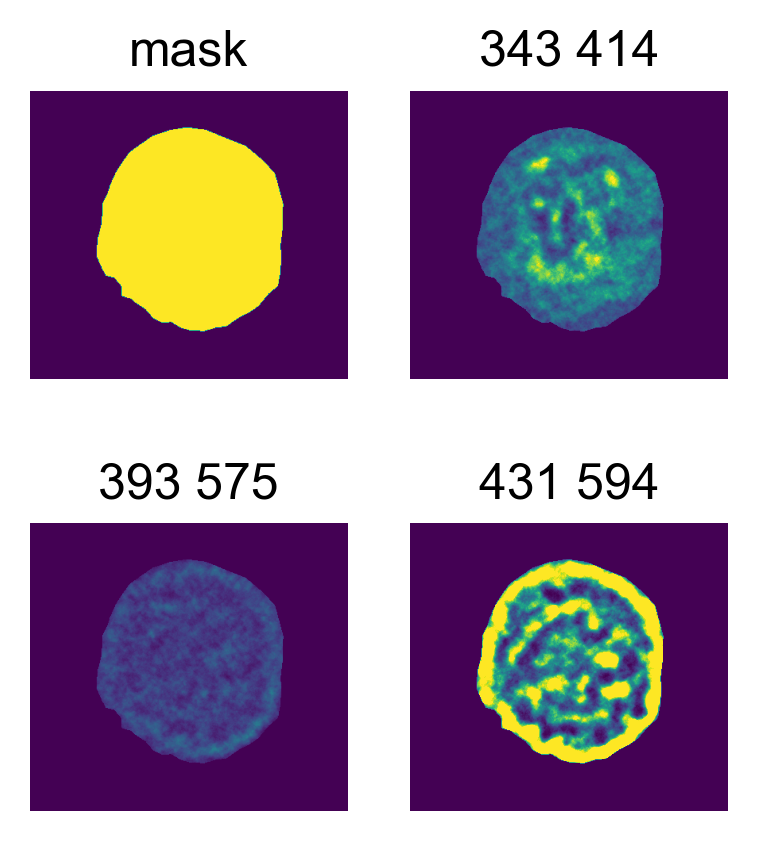

In [33]:
# Panel 3 of figure 1
# plot 3 chaneels and the mask of segmented cells
# M5_S37 as the example

npz_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/'
save_path = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/figure1/'

fns = ['H3_S6.npz']

for i, fn in enumerate(fns):

    image = np.load(npz_fdn + fn)
    sample = fn.split('.')[0]
    
    print(f'This is the {i} cell {sample}')
    fig, axs = plt.subplots(2, 2, figsize=(3, 3.5), dpi=300)
    rcParams['pdf.fonttype'] = 42
    axs = axs.ravel()

    for i, file in enumerate([image.files[j] for j in [16, 2, 8, 13]]):
#         dd = (image[file] / image[file].max() * 255).astype(np.uint8)
#         dd_nor = (dd * 30.0 / np.bincount(dd.ravel()).argmax()).astype(np.uint8)
        
        axs[i].imshow(image[file] * image['new_segmentation'], vmax=[None, 10000][i != 0]) # cmap='gray'
        if i != 0:
            axs[i].set_title('{} {}'.format(file.split('_')[1], file.split('_')[2]) )
        axs[i].axis('off')
    axs[0].set_title('mask')
    plt.savefig(save_path + sample + '_2.png', bbox_inches='tight')
    plt.savefig(save_path + sample + '_2.pdf', bbox_inches='tight')

This is the 0 cell H3_S6


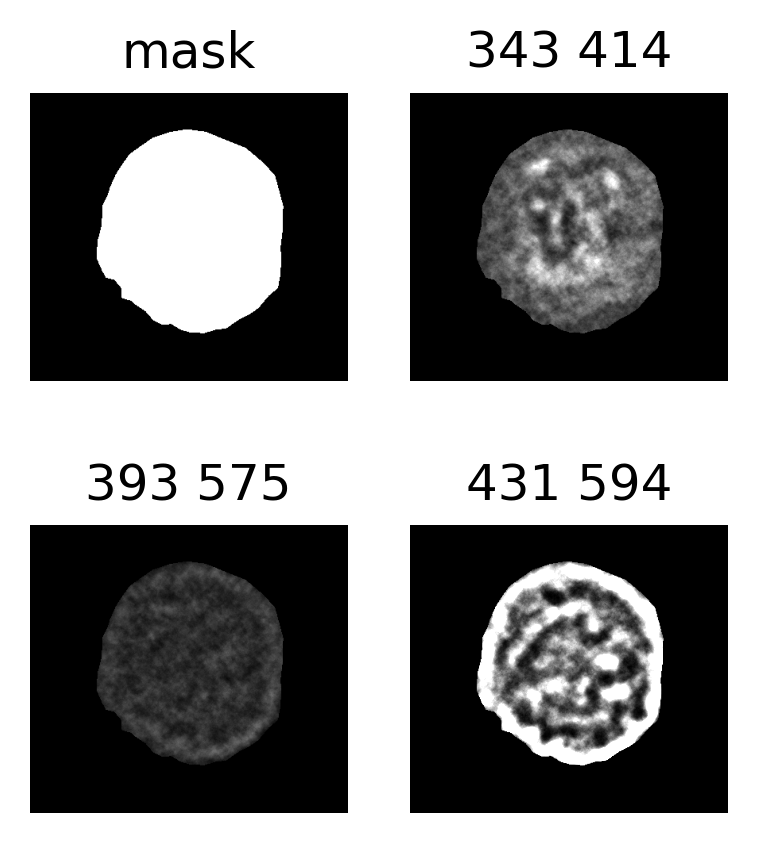

In [7]:
# Panel 3 of figure 1
# plot 3 chaneels and the mask of segmented cells
# M5_S37 as the example

npz_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/'
save_path = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/figure1/'

fns = ['H3_S6.npz']

for i, fn in enumerate(fns):

    image = np.load(npz_fdn + fn)
    sample = fn.split('.')[0]
    
    print(f'This is the {i} cell {sample}')
    fig, axs = plt.subplots(2, 2, figsize=(3, 3.5), dpi=300)
    rcParams['pdf.fonttype'] = 42
    axs = axs.ravel()

    for i, file in enumerate([image.files[j] for j in [16, 2, 8, 13]]):
#         dd = (image[file] / image[file].max() * 255).astype(np.uint8)
#         dd_nor = (dd * 30.0 / np.bincount(dd.ravel()).argmax()).astype(np.uint8)
        
        axs[i].imshow(image[file] * image['new_segmentation'], 
                      vmax=[None, 10000][i != 0], cmap='gray') # cmap='gray'
        if i != 0:
            axs[i].set_title('{} {}'.format(file.split('_')[1], file.split('_')[2]) )
        axs[i].axis('off')
    axs[0].set_title('mask')
    plt.savefig(save_path + sample + '.png', bbox_inches='tight')
    plt.savefig(save_path + sample + '.pdf', bbox_inches='tight')

plot bubble spectrum


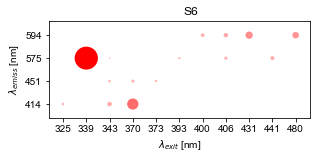

In [32]:
# Panel 4 of figure 1
def plot_bubble_spectrum(spectrum, wls):
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    wls_ex = list(np.unique([x[0] for x in wls]))
    wls_em = list(np.unique([x[1] for x in wls]))
    nex = len(wls_ex)
    nem = len(wls_em)
    smax = spectrum.max()
    snorm = spectrum / smax

    fig, ax = plt.subplots(figsize=(0.1 + 0.4 * nex, 0.8 + 0.4 * nem))
    for (wex, wem), val in zip(wls, snorm):
        y = wls_em.index(wem)
        x = wls_ex.index(wex)
        r = (3 + 97 * val) / 200.
        alpha = 0.2 + 0.8 * val
        h = plt.Circle(
            (x, y), r, ec='none', fc='red', alpha=alpha,
            )
        ax.add_artist(h)
    ax.set_ylim(-0.6, nem - 0.4)
    ax.set_xlim(-0.6, nex - 0.4)
    ax.set_yticks(np.arange(nem))
    ax.set_xticks(np.arange(nex))
    ax.set_yticklabels([str(x) for x in wls_em])
    ax.set_xticklabels([str(x) for x in wls_ex])
    ax.set_ylabel('$\lambda_{emiss}$ [nm]')
    ax.set_xlabel('$\lambda_{exit}$ [nm]')

    fig.tight_layout()
    return {
        'fig': fig,
        'ax': ax,
    }

# spectra example of M5_S37
print('plot bubble spectrum')

npz_fdn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/cancer100cells/'
save_path = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/figure1/'

fn = 'H3_S6.npz'

img = np.load(npz_fdn + fn)
spectras = np.array([(img[i] * img['new_segmentation']).sum() for i in img.files[1:-1]])
wls = [(int(i.split('_')[1]), int(i.split('_')[2])) for i in img.files[1:-1]]

bb_plot = plot_bubble_spectrum(spectras, wls)['fig']
title = fn.split('.')[0].split('_')[1]
bb_plot.suptitle(title, x=0.6, y=0.9)
bb_plot.tight_layout()

bb_plot.savefig(save_path + title + '_bubble.png', bbox_inches='tight', dpi=300)
bb_plot.savefig(save_path + title + '_bubble.pdf', bbox_inches='tight', dpi=300)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


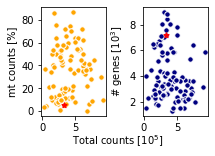

In [7]:
# Panel 5 of figure 1
# QC of gene reads dataset
adata = sc.read_h5ad('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad')
adata = adata[adata.obs['doublets'] != 'Yes']
sample = 'H3_S6' #'M5_S37'

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# (adata.obs['pct_counts_mt'] <= 25).sum() # 37

fig, axs = plt.subplots(1, 2, figsize=(3, 2), sharex=True)
plt.subplots_adjust(wspace=0.55)
axs[0].scatter(x=adata.obs['total_counts']/(10**5), y=adata.obs['pct_counts_mt'], 
               c='orange', edgecolor='white', s=30)
axs[0].scatter(x=adata.obs['total_counts'].loc[sample]/(10**5),
               y=adata.obs['pct_counts_mt'].loc[sample] , c='red', marker=(5, 1), s=30)

axs[1].scatter(x=adata.obs['total_counts']/(10**5), y=adata.obs['n_genes_by_counts']/(10**3), 
               c='navy', edgecolor='white', s=30)
axs[1].scatter(x=adata.obs['total_counts'].loc[sample]/(10**5), 
               y=adata.obs['n_genes_by_counts'].loc[sample]/(10**3), c='red', marker=(5, 1), s=30)

axs[0].set_ylabel('mt counts [%]')
axs[1].set_ylabel('# genes [$10^3$]')
fig.text(0.48, -0.05, 'Total counts [$10^5$]', va='center', ha='center')

save_path = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/figure1/'
fig.savefig(save_path + 'QC2.png', bbox_inches='tight', dpi=300)
fig.savefig(save_path + 'QC2.pdf', bbox_inches='tight', dpi=300)

In [9]:
fig.savefig(save_path + 'QC2.png', bbox_inches='tight', dpi=300)
fig.savefig(save_path + 'QC2.pdf', bbox_inches='tight', dpi=300)

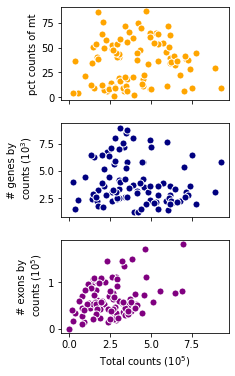

In [192]:
# QC with exon dataset
if False:
    adata_exon = sc.read_h5ad('/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/exon_filter.h5ad')
    adata_exon.var_names_make_unique()
    adata_exon = adata_exon[:, adata_exon.var_names[: -5]]
    adata_exon = adata_exon[(adata_exon.obs['#feature'] != 'FALSE') & (adata_exon.obs['doublets'] == 'No')]

    #sc.pp.filter_cells(adata_exon, min_genes=0)
    sc.pp.filter_genes(adata_exon, min_cells=3)
    adata_exon.var['mt'] = adata_exon.var.gene_name.str.startswith('MT-') 
    sc.pp.calculate_qc_metrics(adata_exon, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    fig, axs = plt.subplots(3, 1, figsize=(3, 6), sharex=True)
    plt.subplots_adjust(hspace=0.25)
    axs[0].scatter(x=adata.obs['total_counts']/(10**5), y=adata.obs['pct_counts_mt'], c='orange', edgecolor='white', s=50)
    axs[1].scatter(x=adata.obs['total_counts']/(10**5), y=adata.obs['n_genes_by_counts']/(10**3), c='navy', edgecolor='white', s=50)
    axs[2].scatter(x=adata_exon.obs['total_counts']/(10**5), y=adata_exon.obs['n_genes_by_counts']/(10**5), c='purple', edgecolor='white', s=50)


    axs[0].set_ylabel('pct counts of mt')
    axs[1].set_ylabel('# genes by\n counts ($10^3$)')
    axs[2].set_ylabel('# exons by\n counts ($10^5$)')

    axs[2].set_xlabel('Total counts ($10^5$)')

    plt.savefig(save_path + 'QC.png', bbox_inches='tight', dpi=300)
    plt.savefig(save_path + 'QC.pdf', bbox_inches='tight', dpi=300)